**Notebook to Calculate Growing Season Rainfall and Reference ET** 

This notebook loads GEE precipitation and reference ET products from TerraClimate and PRISM, and reads a file with timeseries county-level grain sorghum planting area from Kansas. 

Tutorials using GEE can be found here. https://soilwater.github.io/pynotes-gee/

In [1]:
# Grain Sorghum Yield Gap Analysis

# Import modules
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AeaYSHAlZ0Q1KVEk1bb6YK_1YmWlnlQ2d2pkP-oTntpY5b3Bup7qSKjbLtw



Successfully saved authorization token.


In [2]:
# Get centroid of Kansas counties
US_states = ee.FeatureCollection('TIGER/2018/Counties')
kansas_counties = US_states.filter(ee.Filter.inList('STATEFP',['20']))
metadata = kansas_counties.getInfo()

In [3]:
# Compute geographic centroid for each county, so that we can retrieve weather data
D = {}
for f in metadata['features']:
    try:
        coords = f['geometry']['coordinates'][0]
        lat = [i[1] for i in coords]
        lon = [i[0] for i in coords]
        name = f['properties']['NAME'].lower()
        D[name] = {'lat':np.mean(lat), 'lon':np.mean(lon)}
        #print(name)
    except:
        continue


In [4]:
# Handle by hand a few counties that have weird geometries and fail the loop above.
# Geographic centroids of these counties are approximate and were determined visually using Google Maps.
D['chautauqua'] = {'lat':37.150631, 'lon':-96.237762}
D['doniphan'] = {'lat':39.794546, 'lon':-95.131120}
D['harper'] = {'lat':37.201506, 'lon': -98.066312}

In [5]:
#Read Downloaded USDA NASS County-level Data
df = pd.read_csv('C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ET/crop_prec_files/model/seminar_22_fall/historic_yield_trend/ks_acres_1930_present.csv')

In [6]:
df.head(3)

,Year,Period,Ag District,Ag District Code,County,County ANSI,Data Item,Value
0,2020,YEAR,CENTRAL,50,BARTON,9,SORGHUM - ACRES PLANTED,87000
1,2020,YEAR,CENTRAL,50,DICKINSON,41,SORGHUM - ACRES PLANTED,37400
2,2020,YEAR,CENTRAL,50,ELLIS,51,SORGHUM - ACRES PLANTED,66000


In [7]:
df = pd.pivot_table(df, index=['County', 'Ag District'], values='Value', columns=['Year'])
df.head(3)

,Year,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
County,Ag District,,,,,,,,,,,,,,,,,,,,,
ALLEN,SOUTHEAST,17890.0,21480.0,18590.0,21270.0,18300.0,14900.0,11600.0,12800.0,8700.0,12000.0,...,NaN,NaN,NaN,1200.0,NaN,800.0,NaN,NaN,NaN,400.0
ANDERSON,EAST CENTRAL,16230.0,18070.0,15670.0,14650.0,10200.0,11100.0,7800.0,7800.0,4600.0,6800.0,...,NaN,1200.0,NaN,NaN,2200.0,900.0,NaN,NaN,1400.0,NaN
ATCHISON,NORTHEAST,3310.0,3480.0,2540.0,2230.0,2000.0,1600.0,890.0,1500.0,630.0,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# County area planted data will be used to calculate a weighted mean value for precipitation, AWD, or reference ET. 
df = df.fillna(0) # set any 0 planting areas to 0 
df = df/df[df.columns].sum() # convert area to % of total area
df['County'] = df.index.get_level_values(0) # establish column for merging dataframes

In [9]:
# Create a climate normal period, climate normals are typically 30 year data products. 
year_list= np.arange(1991, 2021) 

In [10]:
# Load gridmet product
PRECIP = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
precip_array = []
rain1 = []

for k,row in df.iterrows():
    
    # Get curent county
    county = row['County'].lower()

    # Get county centroid and define GEE point
    lat = D[county]['lat']
    lon = D[county]['lon']
    point = ee.Geometry.Point([lon,lat])
    
    for y in year_list:
        start_date = f"{y}-06-01" # Set dates to GSR period
        end_date = f"{y}-10-31"   

        # Retrieve precipitation data
        pr = PRECIP.filterDate(start_date, end_date).select('pr').getRegion(point, scale=1).getInfo() # pr does not have a scale factor

        # Put precipitation data into a dataframe
        df_pr = pd.DataFrame(pr[1:])
        df_pr.columns = pr[0]

        rain = (df_pr['pr'].sum()) #add all observations 
        rain1.append(rain)
        
    precip_array.append(sum(rain1)/30) # divide by 30 years for a yearly mean
    rain1 = [] # empty for the next county loop
        
    # When loop is done, add precipitation as a new column to dataframe
df['TERRA_Prec'] = np.round(precip_array)

In [11]:
# Load gridmet product
ET = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
precip_array = []
rain1 = []

for k,row in df.iterrows():
    
    # Get curent county
    county = row['County'].lower()

    # Get county centroid and define GEE point
    lat = D[county]['lat']
    lon = D[county]['lon']
    point = ee.Geometry.Point([lon,lat])
    
    for y in year_list:
        start_date = f"{y}-06-01" # Set dates to GSR period
        end_date = f"{y}-10-31"   

        # Retrieve precipitation data
        pr = ET.filterDate(start_date, end_date).select('pet').getRegion(point, scale=1).getInfo() 

        # Put precipitation data into a dataframe
        df_pr = pd.DataFrame(pr[1:])
        df_pr.columns = pr[0]

        rain = (df_pr['pet'].sum()*.1) # pet has .1 scaling factor
        rain1.append(rain)
        
    precip_array.append(sum(rain1)/30)
    rain1 = [] # empty for the next loop
        
    
df['RET'] = np.round(precip_array)

In [12]:
# Calculate Atmospheric Water Deficit
df['AWD']= df['TERRA_Prec']-df['RET']
df.head(3)

,Year,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,...,2015,2016,2017,2018,2019,2020,County,TERRA_Prec,RET,AWD
County,Ag District,,,,,,,,,,,,,,,,,,,,,
ALLEN,SOUTHEAST,0.005129,0.005585,0.006087,0.007826,0.008112,0.006059,0.004913,0.004016,0.002100,0.004598,...,0.000000,0.000406,0.0,0.0,0.00000,0.000145,ALLEN,572.0,725.0,-153.0
ANDERSON,EAST CENTRAL,0.004653,0.004698,0.005131,0.005390,0.004521,0.004514,0.003304,0.002447,0.001110,0.002605,...,0.001204,0.000457,0.0,0.0,0.00191,0.000000,ANDERSON,571.0,722.0,-151.0
ATCHISON,NORTHEAST,0.000949,0.000905,0.000832,0.000820,0.000887,0.000651,0.000377,0.000471,0.000152,0.000536,...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,ATCHISON,547.0,685.0,-138.0


In [13]:
df[['TERRA_Prec']].groupby(by='Ag District').mean()

Year,TERRA_Prec
Ag District,
CENTRAL,427.000000
EAST CENTRAL,544.571429
NORTH CENTRAL,421.181818
NORTHEAST,534.636364
NORTHWEST,315.875000
SOUTH CENTRAL,411.538462
SOUTHEAST,543.642857
SOUTHWEST,293.000000
WEST CENTRAL,299.888889


In [14]:
df[['RET']].groupby(by='Ag District').mean()

Year,RET
Ag District,
CENTRAL,823.090909
EAST CENTRAL,723.071429
NORTH CENTRAL,786.454545
NORTHEAST,700.454545
NORTHWEST,838.750000
SOUTH CENTRAL,864.692308
SOUTHEAST,747.642857
SOUTHWEST,919.071429
WEST CENTRAL,882.555556


In [15]:
df[['AWD']].groupby(by='Ag District').mean()

Year,AWD
Ag District,
CENTRAL,-396.090909
EAST CENTRAL,-178.500000
NORTH CENTRAL,-365.272727
NORTHEAST,-165.818182
NORTHWEST,-522.875000
SOUTH CENTRAL,-453.153846
SOUTHEAST,-204.000000
SOUTHWEST,-626.071429
WEST CENTRAL,-582.666667


In [16]:
# State Weighted RET Mean By Decadal Period 
RET = df.iloc[:, 0:78].mul(df['RET'], 0) # multiply by the weight

print('1940s' ,RET.iloc[:,0:8].sum().mean())
print('1950s' ,RET.iloc[:,8:18].sum().mean())
print('1960s' ,RET.iloc[:,18:28].sum().mean())
print('1970s', RET.iloc[:,28:38].sum().mean())
print('1980s', RET.iloc[:,38:48].sum().mean())
print('1990s' ,RET.iloc[:,48:58].sum().mean())
print('2000s', RET.iloc[:,58:68].sum().mean())
print('2010s', RET.iloc[:,68:80].sum().mean())

1940s 840.8314104455611
1950s 847.9149901834382
1960s 826.4207916094316
1970s 809.9665435863426
1980s 819.19401327984
1990s 815.5466869206882
2000s 838.1417938017657
2010s 860.0860286531304


In [17]:
# State Weighted Precipitation Mean By Decadal Period 
PREC = df.iloc[:, 0:78].mul(df['TERRA_Prec'], 0) # multiply by the weight

print('1940s' ,PREC.iloc[:,0:8].sum().mean())
print('1950s' ,PREC.iloc[:,8:18].sum().mean())
print('1960s' ,PREC.iloc[:,18:28].sum().mean())
print('1970s', PREC.iloc[:,28:38].sum().mean())
print('1980s', PREC.iloc[:,38:48].sum().mean())
print('1990s' ,PREC.iloc[:,48:58].sum().mean())
print('2000s', PREC.iloc[:,58:68].sum().mean())
print('2010s', PREC.iloc[:,68:80].sum().mean())

1940s 390.89801709011635
1950s 375.2699428862844
1960s 402.65421664222697
1970s 426.6915948234384
1980s 413.44097569808184
1990s 419.8045570055321
2000s 388.57125563845136
2010s 356.5826783250116


In [18]:
# Compute Yearly State Weighted Mean for AWD 
AWD_Balance = df.iloc[:, 0:78].mul(df['AWD'], 0)

st_range = np.arange(0,78)
en_range = np.arange(1,79)
awd = []

for s,e in zip(st_range, en_range):
    value = AWD_Balance.iloc[:,s:e].sum().mean()   
    awd.append(value)

In [19]:
AWD_Kanas= pd.DataFrame({'AWD':awd, 'Year':AWD_Balance.columns})

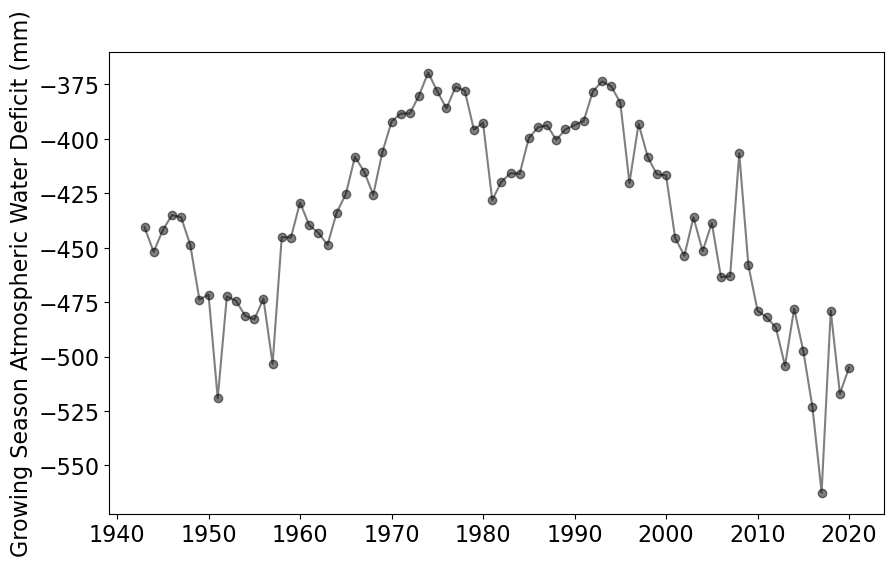

In [20]:
# Figure of inputs (growing season precipitation) vs output (grain yield)
plt.figure(figsize=(10,6))
plt.scatter(AWD_Kanas['Year'], AWD_Kanas['AWD'], color='k', alpha=0.5)
plt.plot(AWD_Kanas['Year'], AWD_Kanas['AWD'], color='k', alpha=0.5)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylabel('Growing Season Atmospheric Water Deficit (mm)', size=16)
plt.show()